In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

import json

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision.models import resnet50, resnet18

from datetime import datetime as dt

import imgaug as ia
import imgaug.augmenters as iaa

from dataset_functions import *
from trainer import *

import tkinter as tk
from PIL import Image, ImageTk
import torchvision.transforms as T

# file containing the dataset (.npy file)
DATASET_FILE = 'C:/Users/gameg/Documents/Code/training_all.npy'

# set to True if running for the first time & there are no trained weights to load
DOWNLOAD_WEIGHTS = True
WEIGHT_FILE = 'resnet18_weights_2022-07-19alldata.pth'

# pick a model (resnet50, resnet18)
MODEL_NAME = 'resnet18'
LOG_NAME = MODEL_NAME + '_alldata_scheduled_5e10bsMSE'


c:\Users\gameg\miniconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# dynamically define whether to run on gpu or cpu
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU")

Running on GPU


Prepare the Dataset:

In [3]:
im_size = 128

# imgaug transforms
seq = iaa.Sequential([
    iaa.Resize({"height": im_size, "width": im_size}),
])

train_X, train_y, test_X, test_y, im_info = load_split_data(DATASET_FILE, seq, validation_percent=0.1)

num_classes = im_info['classes']
im_chan = im_info['channels']
im_size = im_info['size']

print(len(train_X), len(train_y))

done loading


100%|██████████| 21990/21990 [00:13<00:00, 1635.52it/s]


done preprocessing


f:\Deep Learning\drinking\dataset_functions.py:234: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  y = torch.Tensor([i[1] for i in training_data])


19791 19791


In [4]:
# Sample of how to interpret the label for a given image (t)
t = test_y[2]
print(t)
print(torch.argmax(t))
if torch.argmax(t) == 1:
    print('true')


tensor([0., 1.])
tensor(1)
true


Working with the model:

In [5]:
# load from resnet modelinternet
print('Downloading ImageNet weights:', DOWNLOAD_WEIGHTS)

if MODEL_NAME == 'resnet50':
    model = resnet50(pretrained=DOWNLOAD_WEIGHTS)
elif MODEL_NAME == 'resnet18':
    model = resnet18(pretrained=DOWNLOAD_WEIGHTS)

# model setup

# Get the number of inputs to the last fully connected layer in the model
num_ftrs = model.fc.in_features
# create a new final fully connected layer that we can train to replace the other fully connected layer
model.fc = nn.Linear(num_ftrs, num_classes)

# load weights from file
weight_file = WEIGHT_FILE

if not DOWNLOAD_WEIGHTS: # load from file
    model.load_state_dict(torch.load(weight_file))

print('Done loading weights')

# add the model to the device
model = model.to(device)

cow_model = Trainer(model, im_size, LOG_NAME, device=device)

# if there is a memory error, lower the batch size (you want a batch size of at least 8 however)
cow_model.BATCH_SIZE = 10
cow_model.EPOCHS = 5
cow_model.learning_rate = 0.001

cow_model.loss_function = nn.MSELoss()
cow_model.optimizer = optim.SGD(model.fc.parameters(), lr=cow_model.learning_rate)
# See: https://coderzcolumn.com/tutorials/artificial-intelligence/pytorch-learning-rate-schedules#2
# step_size is after how many epochs/batches to update the LR
# gamma is how much to multiply the learning rate by at each step
cow_model.scheduler = lr_scheduler.StepLR(cow_model.optimizer, step_size=2, gamma=0.8, verbose=True)

# set to evaluation mode
# model.eval()

Done loading weights
Adjusting learning rate of group 0 to 1.0000e-03.


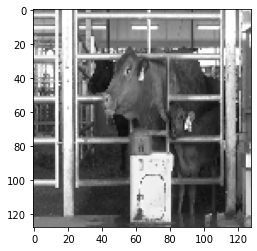

In [6]:
plt.imshow(train_X[0].permute(1,2,0))
plt.show()

In [7]:
# Transfer learning

# freeze all the layers
for param in model.parameters():
    param.requires_grad = False

# unfreeze the final fully connected layer
model.fc.requires_grad_(True)

print(im_chan)

val_acc, val_loss, res, lab = cow_model.test(test_X=test_X, test_y=test_y)

print(f'Before Training: acc={val_acc}, loss={val_loss}')

cow_model.train(train_X, train_y, validate=True, val_steps=50, test_X=test_X, test_y=test_y)


# print('Fine-tuning')
# # Fine-tune for one epoch:

# # unfreeze all the layers
# for param in model.parameters():
#     param.requires_grad = True

# # train for 1 epoch
# cow_model.EPOCHS = 1
# cow_model.modelname=LOG_NAME+'_2',
# cow_model.train(train_X, train_y, validate=True, val_steps=50, test_X=test_X, test_y=test_y)


3
Before Training: acc=0.5625, loss=1.1309921741485596


100%|██████████| 1980/1980 [02:40<00:00, 12.36it/s]


Adjusting learning rate of group 0 to 1.0000e-03.


100%|██████████| 1980/1980 [02:40<00:00, 12.35it/s]


Adjusting learning rate of group 0 to 8.0000e-04.


100%|██████████| 1980/1980 [03:03<00:00, 10.77it/s]


Adjusting learning rate of group 0 to 8.0000e-04.


100%|██████████| 1980/1980 [03:21<00:00,  9.81it/s]


Adjusting learning rate of group 0 to 6.4000e-04.


100%|██████████| 1980/1980 [03:21<00:00,  9.81it/s]

Adjusting learning rate of group 0 to 6.4000e-04.


In [8]:
val_acc, val_loss, bad_results, bad_labels = cow_model.test(test_X=test_X, test_y=test_y, size=(len(test_y)-1))

print(f'After Training: acc={val_acc}, loss={val_loss}')
print(f'{len(bad_results)} incorrect predictions')


After Training: acc=0.9203821656050956, loss=0.22249597311019897
175 incorrect predictions


In [27]:
print(len(test_y))

2199


In [11]:
# Save the model: https://towardsdatascience.com/everything-you-need-to-know-about-saving-weights-in-pytorch-572651f3f8de

model_out_path = fix_filename(f'{LOG_NAME}_weights_{dt.datetime.now().isoformat()}.pth')

# save the model weights (the state_dict)
# NOTE: Must be loaded to an already-defined resnet50 architecture
torch.save(model.state_dict(), model_out_path)

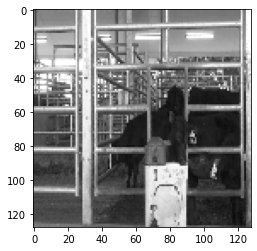

EMPTY


In [9]:
trans = T.ToPILImage()

bad_images = [trans(i.cpu()) for i in bad_results]
bad_labels = [i.cpu() for i in bad_labels]

LABELS = {"0": "EMPTY", "1": "COW"}

plt.imshow(bad_images[0])
plt.show()

print(LABELS[str(bad_labels[0].item())])

In [10]:

class app():

    im_to_show = 0

    def __init__(self, x, y):
        self.root = tk.Tk()
        self.canvas = tk.Canvas(self.root, width=x, height=y)
        self.canvas.pack()

        Bu = tk.Button(self.root, text ="^", command = self.upim)
        Bd = tk.Button(self.root, text ="v", command = self.downim)

        Bu.pack()
        Bd.pack()

        # self.canvas.create_image((x/2)-60,y/2,anchor=tk.NW,image=self.img)
        # self.canvas.create_text(x/2, (y/2)-10, text=self.txt, fill="black", font=('Helvetica 12 bold'))
        self.canvas.pack

        self.root.mainloop()

    def upim(self):
        self.im_to_show = (self.im_to_show + 1) % len(bad_images)
        txt = LABELS[str(bad_labels[self.im_to_show].item())]

        self.canvas.delete('all')
        img = ImageTk.PhotoImage(bad_images[self.im_to_show])

        self.canvas.create_image((x/2)-60,y/2,anchor=tk.NW,image=img)
        self.canvas.create_text(x/2, (y/2)-10, text=txt, fill="black", font=('Helvetica 12 bold'))
        # for some unknown reason, the below line NEEDS to be here, even though it doesnt work
        self.canvas.create_text(x/2, (y/2)-10, text=self.txt, fill="black", font=('Helvetica 12 bold'))


    def downim(self):
        self.im_to_show = self.im_to_show - 1 if self.im_to_show - 1 >= 0 else len(bad_images) - 1
        txt = LABELS[str(bad_labels[self.im_to_show].item())]

        self.canvas.delete('all')
        img = ImageTk.PhotoImage(bad_images[self.im_to_show])

        self.canvas.create_image((x/2)-60,y/2,anchor=tk.NW,image=img)
        self.canvas.create_text(x/2, (y/2)-10, text=txt, fill="black", font=('Helvetica 12 bold'))
        # for some unknown reason, the below line NEEDS to be here, even though it doesnt work
        self.canvas.create_text(x/2, (y/2)-10, text=self.txt, fill="black", font=('Helvetica 12 bold'))

x, y = 400, 400

app(x, y)

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\gameg\miniconda3\envs\pytorch\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "C:\Users\gameg\AppData\Local\Temp\ipykernel_4636\912315237.py", line 32, in upim
    self.canvas.create_text(x/2, (y/2)-10, text=self.txt, fill="black", font=('Helvetica 12 bold'))
AttributeError: 'app' object has no attribute 'txt'
Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\gameg\miniconda3\envs\pytorch\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "C:\Users\gameg\AppData\Local\Temp\ipykernel_4636\912315237.py", line 32, in upim
    self.canvas.create_text(x/2, (y/2)-10, text=self.txt, fill="black", font=('Helvetica 12 bold'))
AttributeError: 'app' object has no attribute 'txt'
Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\gameg\miniconda3\envs\pytorch\lib\tkinter\__init__.py", li